In [1752]:
import torch
import torch.nn as nn
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas_datareader as pdr
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler

In [1753]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [1754]:
initial_labels = train.columns

## Lets take care of the categorical variables

In [1755]:
Categorical = ['MasVnrType','MSSubClass','MSZoning','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrArea','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Heating','HeatingQC','CentralAir','Electrical','KitchenQual','Functional','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond','PavedDrive','PoolQC','Fence','MiscFeature','SaleType','SaleCondition']


In [1756]:
for cat in Categorical:
    train[cat] = train[cat].map(str)
    test[cat] = test[cat].map(str)

In [1757]:
train = train.set_index('Id')
test = test.set_index('Id')
print("index reset")

index reset


In [1758]:
ohe = OneHotEncoder(handle_unknown = 'ignore')
train_ohe = ohe.fit_transform(train[Categorical]).toarray()
test_ohe = ohe.transform(test[Categorical]).toarray()

In [1759]:
feature_labels = ohe.categories_

In [1760]:
labels = []
for names in feature_labels:
    labels += names.tolist()


In [1761]:
train_cat_index = train.index
test_cat_index = test.index

In [1762]:
train_cat = pd.DataFrame(train_ohe,columns=labels)
test_cat = pd.DataFrame(test_ohe,columns=labels)

In [1763]:
train_cat['Id'] = train_cat_index
train_cat = train_cat.set_index(['Id'])
test_cat['Id'] = test_cat_index
test_cat = test_cat.set_index(['Id'])

In [1764]:
#recombine with numerical data now
numerical = []

for name in initial_labels:
    if name not in Categorical and name != 'SalePrice' and name !='Id':
        numerical.append(name)

train_num = train[numerical]
test_num = test[numerical]

In [1765]:
#grab targets
train_target = train['SalePrice']
traing_target = train_target.fillna(train_target.mean())

In [1766]:
#concatenate the numerical and categorical features
train_features= train_num.join(train_cat)
test_features= test_num.join(test_cat)

In [1767]:
train_features = train_features.apply(lambda x: x.fillna(x.mean()),axis=0)
test_features = test_features.apply(lambda x: x.fillna(x.mean()),axis=0)

## Let's scale our values to achieve numerical stability

In [1768]:
mms = MinMaxScaler()

train_features = mms.fit_transform(train_features)
test_features = mms.transform(test_features)

In [1769]:
train_features.shape,test_features.shape

((1460, 645), (1459, 645))

In [1770]:
mms_targets = MinMaxScaler()
train_targets = mms_targets.fit_transform(pd.DataFrame(train_target))

## I want a validation set too...

In [1771]:
x_train,x_val,y_train,y_val = train_test_split(train_features,train_targets,test_size = .1)

# Time to build a model

In [1772]:
x_train = torch.tensor(x_train,dtype=torch.float32)
x_val = torch.tensor(x_val,dtype=torch.float32)
y_train = torch.tensor(y_train,dtype = torch.float32)
y_val = torch.tensor(y_val,dtype=torch.float32)

In [1773]:
inputSize = x_train.shape[1]
bottleNeck = 32
bottleNeck1 = bottleNeck
bottleNeck2 = 16
bottleNeck3 = 8
outputSize = 1
learning_rate = 0.01
epochs = 50

In [1774]:
cost = nn.MSELoss()

In [1775]:
class ThreeLayerFFNN(nn.Module):
    
    def __init__(self,inputSize,bottleNeck1,bottleNeck2,bottleNeck3,outputSize):
        super().__init__()
        self.inputSize = inputSize
        self.bottleNeck1 = bottleNeck1
        self.bottleNeck2 = bottleNeck2
        self.bottleNeck3 = bottleNeck3
        self.outputSize = outputSize
        self.ReLU = nn.ReLU()
        self.net = nn.Sequential(nn.Linear(self.inputSize,self.bottleNeck1),self.ReLU,nn.Linear(self.bottleNeck1,self.bottleNeck2),self.ReLU,nn.Linear(self.bottleNeck2,self.bottleNeck3),self.ReLU,nn.Linear(self.bottleNeck3,self.outputSize)) 
        
    def forward(self,x):
        return(self.net(x))

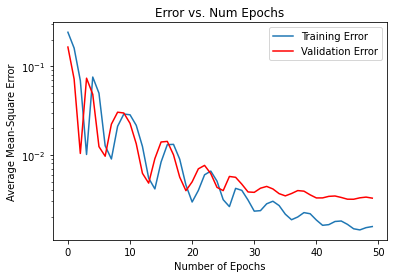

In [1776]:
net = ThreeLayerFFNN(inputSize,bottleNeck1,bottleNeck2,bottleNeck3,outputSize)
optim = torch.optim.Adam(net.parameters(),lr=learning_rate)

loss_list = []
val_loss_list = []

for epoch in range(epochs):
    
    optim.zero_grad()
    y_hat = net(x_train)
    loss = cost(y_hat,y_train)
    loss.backward()
    optim.step()
    loss_list.append(loss.item())
    
    
    loss2 = cost(net(x_val),y_val)
    val_loss_list.append(loss2.item())
    
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

hist = pd.DataFrame(loss_list)#
hist.rename(columns={0:"Training Error"},inplace=True)
hist2 = pd.DataFrame(val_loss_list)
hist2.rename(columns={0:"Validation Error"},inplace = True)

fig = sns.lineplot(data = hist)
fig = sns.lineplot(data = hist2,palette=['r'])
fig.set(xlabel="Number of Epochs",ylabel="Average Mean-Square Error",title = "Error vs. Num Epochs")
fig.set_yscale('log')

In [1777]:
val_loss_list[-1]

0.003247306915000081

In [1778]:
x_test = torch.tensor(test_features,dtype=torch.float32)

In [1779]:
y_hat_test = mms_targets.inverse_transform(net(x_test).detach().numpy())

In [1780]:
output = pd.DataFrame(y_hat_test,columns=['SalePrice'])
output['Id'] = test.index
output.set_index('Id',inplace=True)

In [1781]:
output.to_csv('Estimate.csv')